In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from torch.optim.lr_scheduler import CosineAnnealingLR
warnings.filterwarnings('ignore')

# === PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 20
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['F', 'H', 'Sad', 'S', 'N']
# === DATASET CLASS ===
class SpectrogramDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.file_names = self.df['file_name'].values
        self.labels = (self.df['label'] - 1).values  # Convert 1-5 to 0-4

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_names[idx])
        image = Image.open(img_path).convert("RGB")

        img_array = np.array(image)
        height, width = img_array.shape[:2]
        left_half = img_array[:, :width//2, :]
        right_half = img_array[:, width//2:, :]
        combined_img = np.vstack((left_half, right_half))
        combined_img = Image.fromarray(combined_img)

        label = self.labels[idx]

        if self.transform:
            combined_img = self.transform(combined_img)

        return combined_img, label, self.file_names[idx]  # Now returning filename too

    def get_labels(self):
        return self.labels

# Load later
#train_dataset = torch.load('train_dataset.pt')
#val_dataset = torch.load('val_dataset.pt')
#test_dataset = torch.load('test_dataset.pt')
# Create data loaders
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#print(f"Training set size: {len(train_dataset)}")
#print(f"Validation set size: {len(val_dataset)}")
#print(f"Test set size: {len(test_dataset)}")

def load_full_dataset(filename):
    data = torch.load(filename)
    return data['images'], data['labels'], data['filenames']

# Example usage:
train_images, train_labels, train_filenames = load_full_dataset('/content/train_dataset_full.pt')
val_images, val_labels, val_filenames = load_full_dataset('/content/val_dataset_full.pt')
test_images, test_labels, test_filenames = load_full_dataset('/content/test_dataset_full.pt')

In [ ]:
# Define transforms for training, validation, and test sets
train_transform = transforms.Compose([
    # transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),  # Data augmentation
    # transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Slightly larger for cropping
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])


# Custom Dataset to handle pre-loaded tensors
class TensorDataset(Dataset):
    def __init__(self, images, labels, filenames, transform=None):
        self.images = images
        self.labels = labels
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)  # Convert tensor to PIL for transforms
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, self.filenames[idx]

# Create datasets
train_dataset = TensorDataset(train_images, train_labels, train_filenames, transform=train_transform)
val_dataset = TensorDataset(val_images, val_labels, val_filenames, transform=val_test_transform)
test_dataset = TensorDataset(test_images, test_labels, test_filenames, transform=val_test_transform)

# Create data loaders
from torch.utils.data import WeightedRandomSampler

# Calculate class weights
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights, len(weights))

# Update your train_loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 652
Validation set size: 81
Test set size: 82


## Grok

In [ ]:
# Load pre-trained ResNet model
model = models.resnet34(pretrained=True)  # Or use resnet50 for better performance

class AttentionResNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = nn.Sequential(*list(base_model.children())[:-2])
        self.attention = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.base(x)
        attention = self.attention(features)
        attended = features * attention
        pooled = self.avgpool(attended)
        flattened = torch.flatten(pooled, 1)
        return self.fc(flattened)

model = AttentionResNet(models.resnet34(pretrained=True), NUM_CLASSES)

for param in model.parameters():
    param.requires_grad = False

# Ensure the final layer is trainable
for param in model.fc.parameters():
  param.requires_grad = True

# Modify the final layer for 5 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move model to device
model = model.to(device)

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-4

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
# Example: lower LR for feature layers, higher for classifier
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adam([
#     {'params': model.layer3.parameters(), 'lr': 1e-7, 'weight_decay': 1e-4},
#     {'params': model.fc.parameters(), 'lr': 1e-3, 'weight_decay': 1e-3}
# ])
# optimizer = optim.Adam([
#     {'params': model.layer4.parameters(), 'lr': 1e-5},
#     {'params': model.layer3.parameters(), 'lr': 1e-6},
#     {'params': model.layer2.parameters(), 'lr': 1e-7},
#     {'params': model.layer1.parameters(), 'lr': 1e-8},
#     {'params': model.conv1.parameters(), 'lr': 1e-8},
#     {'params': model.fc.parameters(), 'lr': 1e-4}
# ])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=1e-3,
                                        steps_per_epoch=len(train_loader),
                                        epochs=EPOCHS,
                                        anneal_strategy='cos')
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Gradually unfreeze layers during training
def unfreeze_layers(model, epoch):
    if epoch >= 5:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch >= 10:
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch >= 15:
        for param in model.layer2.parameters():
            param.requires_grad = True

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    save_path='best_grok_acc.pth'
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        # Save checkpoint if validation improves
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_grok_loss.pth')
          print(f"✅ Saved best model with validation loss: {best_val_loss:.4f} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/100]
Train Loss: 1.6491, Train Acc: 17.48%
Val Loss: 1.6249, Val Acc: 23.46%
✅ Saved best model with validation loss: 1.6249 
✅ Best model saved with validation accuracy: 23.4568
Epoch [2/100]
Train Loss: 1.6252, Train Acc: 15.95%
Val Loss: 1.6284, Val Acc: 13.58%
Epoch [3/100]
Train Loss: 1.6281, Train Acc: 18.87%
Val Loss: 1.6205, Val Acc: 13.58%
✅ Saved best model with validation loss: 1.6205 
Epoch [4/100]
Train Loss: 1.6233, Train Acc: 18.40%
Val Loss: 1.6118, Val Acc: 13.58%
✅ Saved best model with validation loss: 1.6118 
Epoch [5/100]
Train Loss: 1.6253, Train Acc: 19.17%
Val Loss: 1.6172, Val Acc: 19.75%
Epoch [6/100]
Train Loss: 1.6079, Train Acc: 22.70%
Val Loss: 1.6252, Val Acc: 16.05%
Epoch [7/100]
Train Loss: 1.6126, Train Acc: 21.17%
Val Loss: 1.6173, Val Acc: 14.81%
Epoch [8/100]
Train Loss: 1.6191, Train Acc: 20.55%
Val Loss: 1.6151, Val Acc: 16.05%
Epoch [9/100]
Train Loss: 1.6157, Train Acc: 19.48%
Val Loss: 1.6095, Val Acc: 16.05%
✅ Saved best model with va

In [ ]:
# Test function
def evaluate_model(model, test_loader, name):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"{name} Test Accuracy: {test_acc:.2f}%")
    return all_preds, all_labels

# Evaluate on test set
all_preds, all_labels = evaluate_model(model, test_loader, "latest")
torch.save(model.state_dict(), 'latest_grok.pth')

model.load_state_dict(torch.load('best_grok_loss.pth'))
all_preds, all_labels = evaluate_model(model, test_loader, "loss")

model.load_state_dict(torch.load('best_grok_acc.pth'))
all_preds, all_labels = evaluate_model(model, test_loader, "acc")

latest Test Accuracy: 24.39%
loss Test Accuracy: 20.73%
acc Test Accuracy: 24.39%


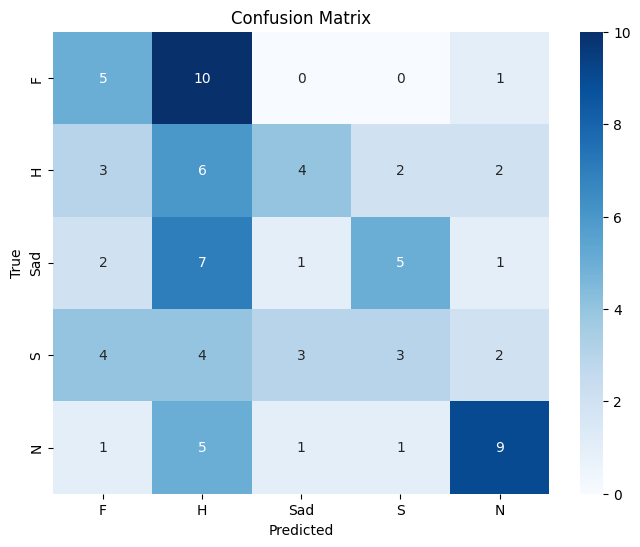

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## ResNet-34

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-6

import torch.nn as nn
import torchvision.models as models

# class ResNet34WithDropout(nn.Module):
#     def __init__(self, dropout_rate=0.5, num_classes=1000):
#         super().__init__()
#         base_model = models.resnet34(pretrained=True)
#         self.features = nn.Sequential(*list(base_model.children())[:-1])  # everything except the last fc
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(base_model.fc.in_features, num_classes)

#     def forward(self, x):
#         x = self.features(x)  # output shape: (B, 512, 1, 1)
#         x = torch.flatten(x, 1)  # shape: (B, 512)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

# Usage
# model = ResNet34WithDropout(dropout_rate=0.3, num_classes=NUM_CLASSES)
model = models.resnet34(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# # Ensure the final layer is trainable
# for param in model.fc.parameters():
#   param.requires_grad = True

import torch.nn as nn

# Replace the final FC layer with:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(512, 256),  # Smaller intermediate layer
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, NUM_CLASSES)
)

# Modify the final layer for 5 classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move model to device
model = model.to(device)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.5)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=1e-3,
                                        steps_per_epoch=len(train_loader),
                                        epochs=EPOCHS,
                                        anneal_strategy='cos')
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint if validation improves
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_34_loss.pth')
          print(f"✅ Saved best model with validation loss: {best_val_loss:.4f} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_34_acc.pth')
            print(f"✅ Best model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/100]
Train Loss: 1.7197, Train Acc: 21.63%
Val Loss: 1.6515, Val Acc: 22.22%
✅ Saved best model with validation loss: 1.6515 
✅ Best model saved with validation accuracy: 22.2222
Epoch [2/100]
Train Loss: 1.7142, Train Acc: 21.63%
Val Loss: 1.6230, Val Acc: 24.69%
✅ Saved best model with validation loss: 1.6230 
✅ Best model saved with validation accuracy: 24.6914
Epoch [3/100]
Train Loss: 1.6982, Train Acc: 20.55%
Val Loss: 1.6364, Val Acc: 28.40%
✅ Best model saved with validation accuracy: 28.3951
Epoch [4/100]
Train Loss: 1.6968, Train Acc: 23.01%
Val Loss: 1.6335, Val Acc: 28.40%
Epoch [5/100]
Train Loss: 1.6988, Train Acc: 23.62%
Val Loss: 1.6278, Val Acc: 23.46%
Epoch [6/100]
Train Loss: 1.6680, Train Acc: 24.85%
Val Loss: 1.6159, Val Acc: 25.93%
✅ Saved best model with validation loss: 1.6159 
Epoch [7/100]
Train Loss: 1.6824, Train Acc: 21.17%
Val Loss: 1.6047, Val Acc: 27.16%
✅ Saved best model with validation loss: 1.6047 
Epoch [8/100]
Train Loss: 1.6659, Train Acc

KeyboardInterrupt: 

In [ ]:
# Test function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return all_preds, all_labels, test_acc

best_acc = 0.0

# Evaluate on test set
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  path = 'latest_34.pth'
torch.save(model.state_dict(), 'latest_34.pth')

model.load_state_dict(torch.load('best_34_loss.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  path = 'best_34_loss.pth'

model.load_state_dict(torch.load('best_34_acc.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  path = 'best_34_acc.pth'

Test Accuracy: 31.71%
Test Accuracy: 31.71%
Test Accuracy: 30.49%


Test Accuracy: 30.49%

Multi-class Confusion Matrix:
     F  H  Sad  S   N
F    7  1    0  4   4
H    5  1    0  4   7
Sad  8  0    0  6   2
S    3  1    1  7   4
N    3  0    1  3  10


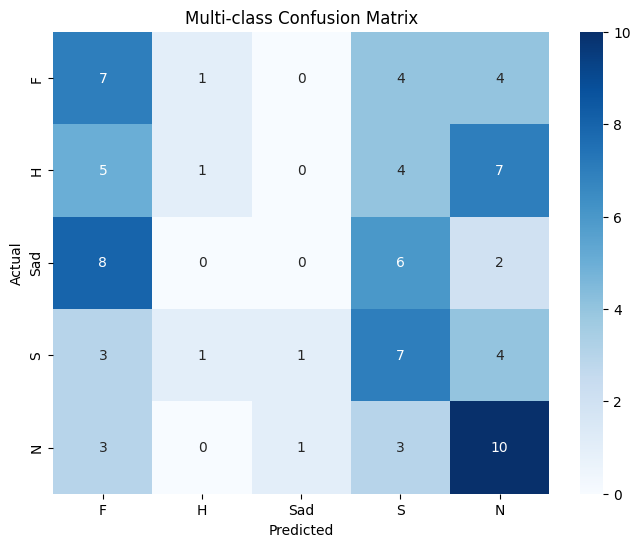

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load(path))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)

# # Plot confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# === CONFUSION MATRIX ===
cm_multi = confusion_matrix(all_labels, all_preds)
cm_multi_df = pd.DataFrame(cm_multi, index=classes, columns=classes)
print("\nMulti-class Confusion Matrix:")
print(cm_multi_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-class Confusion Matrix')
plt.show()

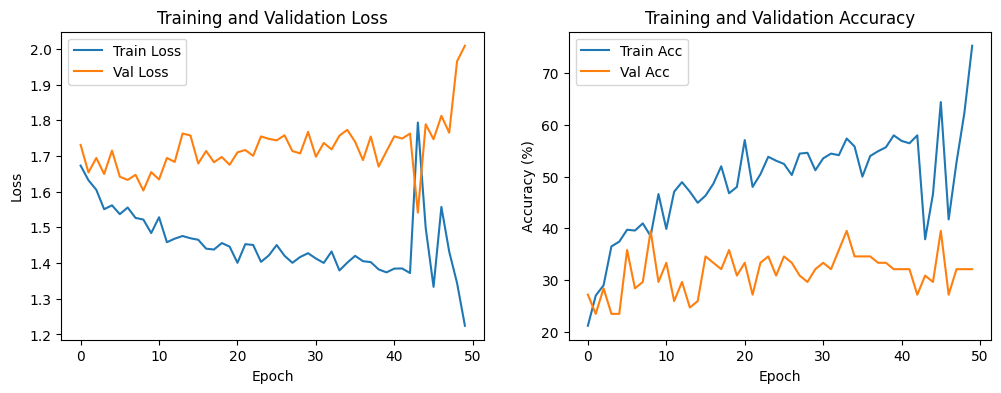

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# === CLASSIFICATION REPORT ===
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# === CLASS-WISE ACCURACY ===
class_accuracy = cm_multi.diagonal() / cm_multi.sum(axis=1)
print("\nClass-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy):
    print(f"{class_name}: {acc:.2%}")  # Format as percentage

# Optional: Create a combined metrics dataframe
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = None  # Add empty column
report_df.loc[classes, 'accuracy'] = class_accuracy  # Fill class accuracies

print("\nCombined Metrics Report:")
print(report_df)


Detailed Classification Report:
              precision    recall  f1-score   support

           F       0.27      0.44      0.33        16
           H       0.33      0.06      0.10        17
         Sad       0.00      0.00      0.00        16
           S       0.29      0.44      0.35        16
           N       0.37      0.59      0.45        17

    accuracy                           0.30        82
   macro avg       0.25      0.30      0.25        82
weighted avg       0.26      0.30      0.25        82


Class-wise Accuracy:
F: 43.75%
H: 5.88%
Sad: 0.00%
S: 43.75%
N: 58.82%

Combined Metrics Report:
              precision    recall  f1-score    support  accuracy
F              0.269231  0.437500  0.333333  16.000000    0.4375
H              0.333333  0.058824  0.100000  17.000000  0.058824
Sad            0.000000  0.000000  0.000000  16.000000       0.0
S              0.291667  0.437500  0.350000  16.000000    0.4375
N              0.370370  0.588235  0.454545  17.000000 

## First Optimizer

In [ ]:
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-4

# Load pre-trained ResNet model
model = models.resnet34(pretrained=True)  # Or use resnet50 for better performance

for param in model.parameters():
    param.requires_grad = False

# Ensure the final layer is trainable
for param in model.fc.parameters():
  param.requires_grad = True

# Modify the final layer for 5 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Modify the final layer for 5 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move model to device
model = model.to(device)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
def get_optimizer(model):
    return torch.optim.Adam([
        {'params': model.conv1.parameters(), 'lr': 1e-5},
        {'params': model.layer1.parameters(), 'lr': 1e-4},
        {'params': model.layer2.parameters(), 'lr': 3e-4},
        {'params': model.layer3.parameters(), 'lr': 5e-4},
        {'params': model.layer4.parameters(), 'lr': 7e-4},
        {'params': model.fc.parameters(),     'lr': 1e-3},
    ], weight_decay=1e-5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=1e-3,
                                        steps_per_epoch=len(train_loader),
                                        epochs=EPOCHS,
                                        anneal_strategy='cos')
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

def unfreeze_layers(model, epoch):
    if epoch >= 43:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch >= 46:
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch >= 48:
        for param in model.layer2.parameters():
            param.requires_grad = True

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        unfreeze_layers(model, epoch)
        optimizer = get_optimizer(model)
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint if validation improves
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_34_loss2.pth')
          print(f"✅ Saved best model with validation loss: {best_val_loss:.4f} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_34_acc2.pth')
            print(f"✅ Best model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/50]
Train Loss: 1.6731, Train Acc: 21.17%
Val Loss: 1.7311, Val Acc: 27.16%
✅ Saved best model with validation loss: 1.7311 
✅ Best model saved with validation accuracy: 27.1605
Epoch [2/50]
Train Loss: 1.6321, Train Acc: 26.99%
Val Loss: 1.6539, Val Acc: 23.46%
✅ Saved best model with validation loss: 1.6539 
Epoch [3/50]
Train Loss: 1.6053, Train Acc: 28.99%
Val Loss: 1.6946, Val Acc: 28.40%
✅ Best model saved with validation accuracy: 28.3951
Epoch [4/50]
Train Loss: 1.5509, Train Acc: 36.50%
Val Loss: 1.6496, Val Acc: 23.46%
✅ Saved best model with validation loss: 1.6496 
Epoch [5/50]
Train Loss: 1.5618, Train Acc: 37.42%
Val Loss: 1.7152, Val Acc: 23.46%
Epoch [6/50]
Train Loss: 1.5371, Train Acc: 39.72%
Val Loss: 1.6419, Val Acc: 35.80%
✅ Saved best model with validation loss: 1.6419 
✅ Best model saved with validation accuracy: 35.8025
Epoch [7/50]
Train Loss: 1.5557, Train Acc: 39.57%
Val Loss: 1.6330, Val Acc: 28.40%
✅ Saved best model with validation loss: 1.6330 
E

In [ ]:
# Test function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return all_preds, all_labels

# Evaluate on test set
all_preds, all_labels = evaluate_model(model, test_loader)
torch.save(model.state_dict(), 'latest_342.pth')

model.load_state_dict(torch.load('best_34_loss2.pth'))
all_preds, all_labels = evaluate_model(model, test_loader)

model.load_state_dict(torch.load('best_34_acc2.pth'))
all_preds, all_labels = evaluate_model(model, test_loader)

Test Accuracy: 28.05%
Test Accuracy: 31.71%
Test Accuracy: 25.61%


## DeepSeek

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-6

import torch.nn as nn
import torchvision.models as models

model = models.resnet34(pretrained=True)

# Replace the final FC layer with:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(512, 256),  # Smaller intermediate layer
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, NUM_CLASSES)
)

# Modify the final layer for 5 classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

for param in model.parameters():
    param.requires_grad = False

# Ensure the final layer is trainable
for param in model.fc.parameters():
  param.requires_grad = True

# Move model to device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 146MB/s]


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# def get_optimizer(model):
#     return torch.optim.Adam([
#         {'params': model.conv1.parameters(), 'lr': 1e-5},
#         {'params': model.layer1.parameters(), 'lr': 1e-4},
#         {'params': model.layer2.parameters(), 'lr': 3e-4},
#         {'params': model.layer3.parameters(), 'lr': 5e-4},
#         {'params': model.layer4.parameters(), 'lr': 7e-4},
#         {'params': model.fc.parameters(),     'lr': 1e-3},
#     ], weight_decay=1e-5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=1e-3,
                                        steps_per_epoch=len(train_loader),
                                        epochs=EPOCHS,
                                        anneal_strategy='cos')
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

def unfreeze_layers(model, epoch):
    if epoch >= 43:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch >= 46:
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch >= 48:
        for param in model.layer2.parameters():
            param.requires_grad = True

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        # unfreeze_layers(model, epoch)
        # optimizer = get_optimizer(model)
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint if validation improves
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_34_loss3.pth')
          print(f"✅ Saved best model with validation loss: {best_val_loss:.4f} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_34_acc3.pth')
            print(f"✅ Best model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/100]
Train Loss: 1.7476, Train Acc: 18.25%
Val Loss: 1.6757, Val Acc: 18.52%
✅ Saved best model with validation loss: 1.6757 
✅ Best model saved with validation accuracy: 18.5185
Epoch [2/100]
Train Loss: 1.7133, Train Acc: 21.78%
Val Loss: 1.6732, Val Acc: 18.52%
✅ Saved best model with validation loss: 1.6732 
Epoch [3/100]
Train Loss: 1.7124, Train Acc: 19.79%
Val Loss: 1.6652, Val Acc: 22.22%
✅ Saved best model with validation loss: 1.6652 
✅ Best model saved with validation accuracy: 22.2222
Epoch [4/100]
Train Loss: 1.7064, Train Acc: 20.40%
Val Loss: 1.6601, Val Acc: 22.22%
✅ Saved best model with validation loss: 1.6601 
Epoch [5/100]
Train Loss: 1.6844, Train Acc: 21.78%
Val Loss: 1.6596, Val Acc: 20.99%
✅ Saved best model with validation loss: 1.6596 
Epoch [6/100]
Train Loss: 1.6922, Train Acc: 22.55%
Val Loss: 1.6542, Val Acc: 23.46%
✅ Saved best model with validation loss: 1.6542 
✅ Best model saved with validation accuracy: 23.4568
Epoch [7/100]
Train Loss: 1.667

In [ ]:
# Test function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return all_preds, all_labels, test_acc

best_acc = 0.0

# Evaluate on test set
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'latest_343.pth'
torch.save(model.state_dict(), 'latest_343.pth')

model.load_state_dict(torch.load('best_34_loss3.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'best_34_loss3.pth'

model.load_state_dict(torch.load('best_34_acc3.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'best_34_acc3.pth'

Test Accuracy: 25.61%
Test Accuracy: 30.49%
Test Accuracy: 29.27%


Test Accuracy: 29.27%

Multi-class Confusion Matrix:
      F  H  Sad  S  N
F    12  0    0  4  0
H    10  2    0  5  0
Sad   7  0    1  8  0
S     9  0    1  6  0
N     5  1    0  8  3


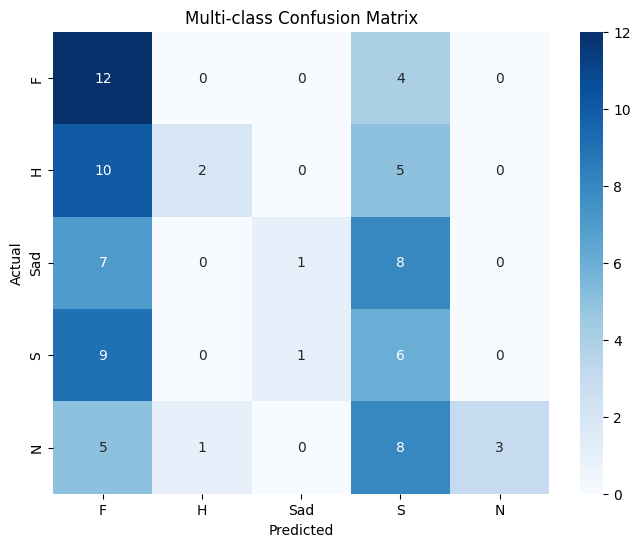

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load(path))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)

# # Plot confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# === CONFUSION MATRIX ===
cm_multi = confusion_matrix(all_labels, all_preds)
cm_multi_df = pd.DataFrame(cm_multi, index=classes, columns=classes)
print("\nMulti-class Confusion Matrix:")
print(cm_multi_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-class Confusion Matrix')
plt.show()

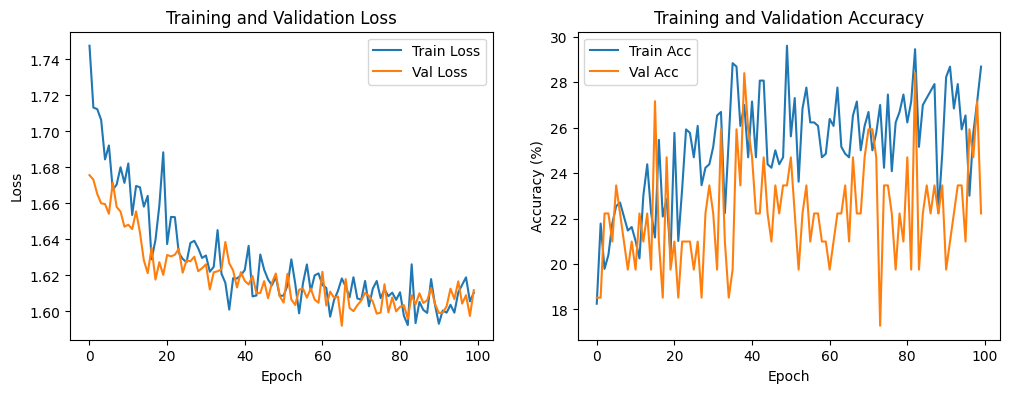

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# === CLASSIFICATION REPORT ===
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# === CLASS-WISE ACCURACY ===
class_accuracy = cm_multi.diagonal() / cm_multi.sum(axis=1)
print("\nClass-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy):
    print(f"{class_name}: {acc:.2%}")  # Format as percentage

# Optional: Create a combined metrics dataframe
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = None  # Add empty column
report_df.loc[classes, 'accuracy'] = class_accuracy  # Fill class accuracies

print("\nCombined Metrics Report:")
print(report_df)


Detailed Classification Report:
              precision    recall  f1-score   support

           F       0.28      0.75      0.41        16
           H       0.67      0.12      0.20        17
         Sad       0.50      0.06      0.11        16
           S       0.19      0.38      0.26        16
           N       1.00      0.18      0.30        17

    accuracy                           0.29        82
   macro avg       0.53      0.30      0.25        82
weighted avg       0.54      0.29      0.25        82


Class-wise Accuracy:
F: 75.00%
H: 11.76%
Sad: 6.25%
S: 37.50%
N: 17.65%

Combined Metrics Report:
              precision    recall  f1-score    support  accuracy
F              0.279070  0.750000  0.406780  16.000000      0.75
H              0.666667  0.117647  0.200000  17.000000  0.117647
Sad            0.500000  0.062500  0.111111  16.000000    0.0625
S              0.193548  0.375000  0.255319  16.000000     0.375
N              1.000000  0.176471  0.300000  17.000000

## MixUp

In [ ]:
BATCH_SIZE = 16
EPOCHS = 30
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-6

import torch.nn as nn
import torchvision.models as models

model = models.resnet34(pretrained=True)

# Replace the final FC layer with:
# model.fc = nn.Sequential(
#     nn.Dropout(0.5),  # Add dropout
#     nn.Linear(512, 256),  # Smaller intermediate layer
#     nn.ReLU(),
#     nn.BatchNorm1d(256),
#     nn.Linear(256, NUM_CLASSES)
# )

# Modify the final layer for 5 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# for param in model.parameters():
#     param.requires_grad = False

# # Ensure the final layer is trainable
# for param in model.fc.parameters():
#   param.requires_grad = True

# Move model to device
model = model.to(device)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# def get_optimizer(model):
#     return torch.optim.Adam([
#         {'params': model.conv1.parameters(), 'lr': 1e-5},
#         {'params': model.layer1.parameters(), 'lr': 1e-4},
#         {'params': model.layer2.parameters(), 'lr': 3e-4},
#         {'params': model.layer3.parameters(), 'lr': 5e-4},
#         {'params': model.layer4.parameters(), 'lr': 7e-4},
#         {'params': model.fc.parameters(),     'lr': 1e-3},
#     ], weight_decay=1e-5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=1e-3,
                                        steps_per_epoch=len(train_loader),
                                        epochs=EPOCHS,
                                        anneal_strategy='cos')
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

def unfreeze_layers(model, epoch):
    if epoch >= 43:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch >= 46:
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch >= 48:
        for param in model.layer2.parameters():
            param.requires_grad = True

def mixup_data(x, y, alpha=0.4):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Modified training function with MixUp
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Apply MixUp
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.4)

            optimizer.zero_grad()
            outputs = model(mixed_images)

            # Use special MixUp loss
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # For accuracy calculation, we use original labels (approximate)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (lam * (predicted == labels_a).float() +
                       (1 - lam) * (predicted == labels_b).float()).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase (no MixUp here)
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoints
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_34_loss4.pth')
            print(f"✅ Saved best model with validation loss: {best_val_loss:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_34_acc4.pth')
            print(f"✅ Best model saved with validation accuracy: {best_val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/30]
Train Loss: 1.6748, Train Acc: 22.29%
Val Loss: 1.7506, Val Acc: 18.52%
✅ Saved best model with validation loss: 1.7506
✅ Best model saved with validation accuracy: 18.52%
Epoch [2/30]
Train Loss: 1.6229, Train Acc: 25.75%
Val Loss: 1.7227, Val Acc: 23.46%
✅ Saved best model with validation loss: 1.7227
✅ Best model saved with validation accuracy: 23.46%
Epoch [3/30]
Train Loss: 1.6269, Train Acc: 24.34%
Val Loss: 1.6503, Val Acc: 27.16%
✅ Saved best model with validation loss: 1.6503
✅ Best model saved with validation accuracy: 27.16%
Epoch [4/30]
Train Loss: 1.6030, Train Acc: 28.11%
Val Loss: 1.6790, Val Acc: 27.16%
Epoch [5/30]
Train Loss: 1.5974, Train Acc: 29.24%
Val Loss: 1.6058, Val Acc: 29.63%
✅ Saved best model with validation loss: 1.6058
✅ Best model saved with validation accuracy: 29.63%
Epoch [6/30]
Train Loss: 1.5933, Train Acc: 31.26%
Val Loss: 1.6714, Val Acc: 27.16%
Epoch [7/30]
Train Loss: 1.5908, Train Acc: 28.59%
Val Loss: 1.6288, Val Acc: 28.40%
Epoch

In [ ]:
# Test function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return all_preds, all_labels, test_acc

best_acc = 0.0

# Evaluate on test set
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'latest_344.pth'
torch.save(model.state_dict(), 'latest_344.pth')

model.load_state_dict(torch.load('best_34_loss4.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'best_34_loss4.pth'

model.load_state_dict(torch.load('best_34_acc4.pth'))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)
if test_acc > best_acc:
  best_acc = test_acc
  path = 'best_34_acc4.pth'

Test Accuracy: 23.17%
Test Accuracy: 28.05%
Test Accuracy: 23.17%


Test Accuracy: 28.05%

Multi-class Confusion Matrix:
     F  H  Sad  S   N
F    3  0    2  7   4
H    4  0    1  6   6
Sad  1  1    2  5   7
S    4  0    6  3   3
N    0  0    2  0  15


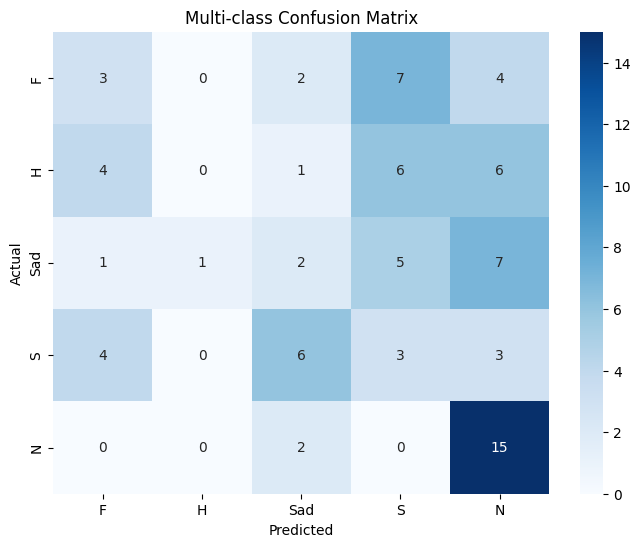

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load(path))
all_preds, all_labels, test_acc = evaluate_model(model, test_loader)

# # Plot confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# === CONFUSION MATRIX ===
cm_multi = confusion_matrix(all_labels, all_preds)
cm_multi_df = pd.DataFrame(cm_multi, index=classes, columns=classes)
print("\nMulti-class Confusion Matrix:")
print(cm_multi_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-class Confusion Matrix')
plt.show()

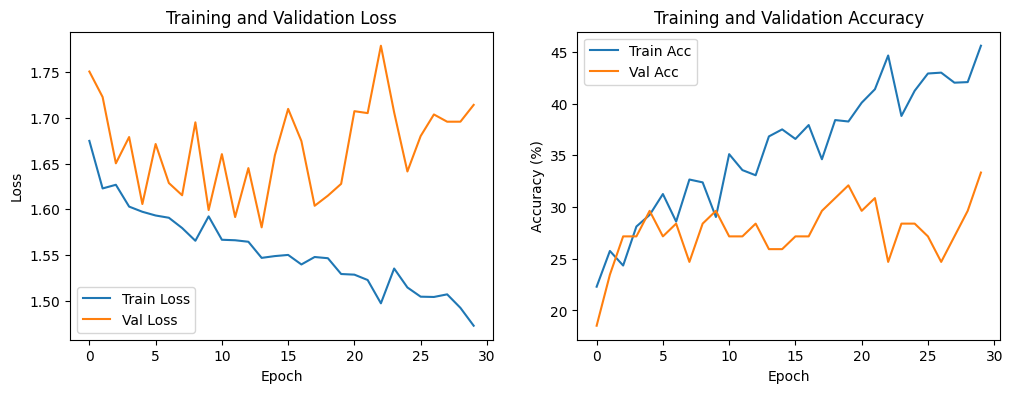

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# === CLASSIFICATION REPORT ===
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# === CLASS-WISE ACCURACY ===
class_accuracy = cm_multi.diagonal() / cm_multi.sum(axis=1)
print("\nClass-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy):
    print(f"{class_name}: {acc:.2%}")  # Format as percentage

# Optional: Create a combined metrics dataframe
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = None  # Add empty column
report_df.loc[classes, 'accuracy'] = class_accuracy  # Fill class accuracies

print("\nCombined Metrics Report:")
print(report_df)


Detailed Classification Report:
              precision    recall  f1-score   support

           F       0.25      0.19      0.21        16
           H       0.00      0.00      0.00        17
         Sad       0.15      0.12      0.14        16
           S       0.14      0.19      0.16        16
           N       0.43      0.88      0.58        17

    accuracy                           0.28        82
   macro avg       0.20      0.28      0.22        82
weighted avg       0.20      0.28      0.22        82


Class-wise Accuracy:
F: 18.75%
H: 0.00%
Sad: 12.50%
S: 18.75%
N: 88.24%

Combined Metrics Report:
              precision    recall  f1-score    support  accuracy
F              0.250000  0.187500  0.214286  16.000000    0.1875
H              0.000000  0.000000  0.000000  17.000000       0.0
Sad            0.153846  0.125000  0.137931  16.000000     0.125
S              0.142857  0.187500  0.162162  16.000000    0.1875
N              0.428571  0.882353  0.576923  17.000000